# Testing TD-Learning

Temporal Difference Learning (TD-Learning) is a set of algorithms for optimizing policies based on the rewards in a time window.

Unlike Monte Carlo methods, the TD-Learning dont need to waint until the end of a episode to update its policy.

In [1]:
import numpy as np
import itertools
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

sys.path.append( os.path.join('..') )
from RLearning.temporal_difference import NStepSarsa
from RLearning.interfaces import TabularInterface

from RLearning.environment import RandomDiscreteWalk

from sklearn.metrics import mean_squared_error

## N-Step TD

N-Step TD is a method that update the state/contro values based on the next N rewards.

That is, a reward of a pair state-action $(S_t,a)$ will be expected to be: 

$G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n} R_{t+1+n}$

Where $n$ is the number of rewards considered in the time window and $\gamma$ is the discount factor of a reward.


The cell bellow executes a convergence test of several N-Step TD agents.

In [5]:
%%time
alpha_values = np.linspace(0, 1, 20)
n_steps_values = 2**np.arange( 0, 9 )

envrioment = RandomDiscreteWalk( n_states=19, step_size=1 )
true_state_values = envrioment.compute_true_solution()

N_REPETITIONS = 100
N_EPISODES = 10

results = []

for alpha, n_steps in itertools.product(alpha_values, n_steps_values):

  repetition_errors = np.zeros( N_REPETITIONS )
  for r in range(N_REPETITIONS):
    agent = NStepSarsa( 
                        episodes=N_EPISODES, 
                        env_interface=TabularInterface(alpha=alpha, alpha_decay="constant"),
                        n_steps=n_steps,
                        off_policy=False
                      )
    agent.fit(envrioment)
    pred_state_values = agent.env_interface.state_value
    repetition_errors[r] = np.sqrt(mean_squared_error(true_state_values, pred_state_values))

  results.append( 
                  {
                   "alpha":alpha,
                   "n_steps":n_steps,
                   "Mean RMSE":np.mean(repetition_errors)
                  }
                )


CPU times: total: 17min 49s
Wall time: 17min 56s


Text(0.5, 1.0, 'RMSE for the 19 States Random Walk\naveraged over the first 10 episodes 100 times')

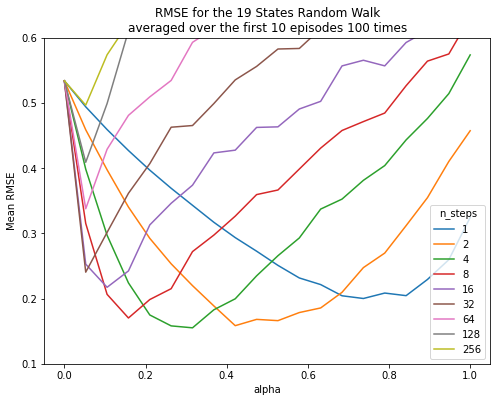

In [6]:
results_df = pd.DataFrame(results)
results_df['n_steps'] = results_df['n_steps'].astype(str)

fig, ax = plt.subplots( figsize=(8,6) )
sns.lineplot(
             data=results_df, 
             x='alpha', y='Mean RMSE', 
             hue='n_steps',
             ax=ax
            )

ax.set_ylim( [0.1, 0.6] )
ax.set_title("RMSE for the 19 States Random Walk\naveraged over the first 10 episodes 100 times")

# Per-decision N-Step

This model is a off-policy approach to N-Step algorithms proposed in *Reinforcement Learning An Introduction*. 

The main idea is described by the equation bellow:

$G_{t:h} \doteq  \rho_{t} ( R_{t+1} + \gamma G_{t+1:h} ) + (1-\rho_{t})V_{h-1}(S_t) $

Where $ \rho_{t} = \frac{ \pi (A_t|S_t) }{ b(A_t|S_t) } $ and $h = t+n$ in the pratical application

In [7]:
%%time
sarsa = NStepSarsa( episodes=10000, n_steps=2, 
                    env_interface=TabularInterface(alpha=0.01, alpha_decay="constant"),
                    off_policy=True, eps=0.231
                  )
envrioment = RandomDiscreteWalk( n_states=10 )
sarsa.fit( envrioment )

print( envrioment.compute_true_solution() )
print( sarsa.env_interface.state_value )
print( sarsa.env_interface.state_action_value )

[-0.81818182 -0.63636364 -0.45454545 -0.27272727 -0.09090909  0.09090909
  0.27272727  0.45454545  0.63636364  0.81818182  0.        ]
[-0.81572005 -0.65331857 -0.43235001 -0.28115294 -0.08174556  0.11037424
  0.27133116  0.45917569  0.66833844  0.84893689  0.        ]
[[-0.81572005]
 [-0.65331857]
 [-0.43235001]
 [-0.28115294]
 [-0.08174556]
 [ 0.11037424]
 [ 0.27133116]
 [ 0.45917569]
 [ 0.66833844]
 [ 0.84893689]
 [ 0.        ]]
CPU times: total: 45.2 s
Wall time: 46.4 s
